Aulas 2 e 3 - Coleta, Organização, Limpeza e Imputação de Dados
===============================================================

Professor: Marcos Cesar Gritti  
Email: cesargritti@gmail.com

Antes de começar:
 - Caso seu ambiente Anaconda não possua uma das dependências necessárias para a execução do código contigo neste notebook, abra uma célula e execute o comando: ```!pip install -r ../requirements.txt```

In [1]:
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from matplotlib.patches import Ellipse

In [2]:
sns.set(font_scale=1.0, rc={
    "figure.figsize": (10, 6),
})

Parte 1 - Detecção de Outliers
========================

Um outlier é um valor atípico ou anômalo encontrado em um conjunto de dados, com o potencial para distorcer análises estatísticas e treinamento de modelos.

Para identificá-los, infelizmente, não existe uma receita mágica. Entretanto, com o uso de ferramentas estatísticas, criatividade e entendimento do problema, podemos encontrar caminhos para eliminá-los de nossa base de estudo.


Para dar suporte ao entendimento deste módulo, segue abaixo algumas expressões frequentemente utilizadas no âmbito de **estatística** para descrever a distribuição de **variáveis aleatórias**:


$X \sim N(\mu, \sigma^2)$, variável aleatória $X$ que segue uma Distribuição Gaussiana (ou Normal) de média $\mu$ e variância $\sigma^2$  
$X \sim U(a, b)$, variável aleatória $X$ que segue uma Distribuição Uniformemente Distribuida no intervalo $[a, b]$  
$X \sim B(p)$, variável aleatória discreta $X$ que segue uma distribuição de Bernoulli com parâmetro $p$

Segue abaixo alguns exemplos de visualização das Funções de Densidade de Probabilidade (FDP, em inglês, *Probability Density Function*, PDF) de algumas distribuições:

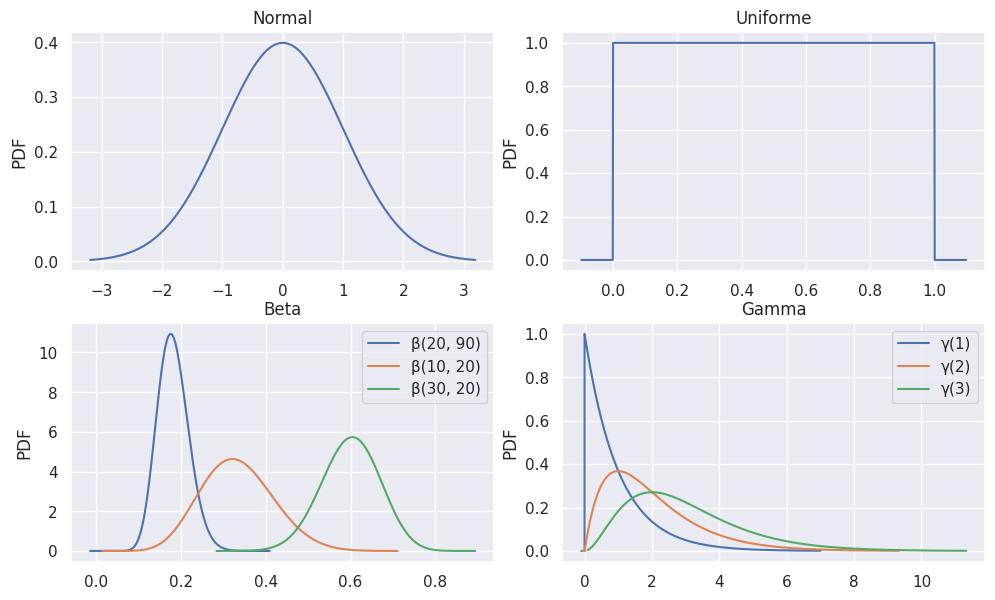

In [3]:
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import beta
from scipy.stats import gamma
import numpy as np

beta_20_90 = beta(20, 90)
beta_10_20 = beta(10, 20)
beta_30_20 = beta(30, 20)
g1 = gamma(1)
g2 = gamma(2)
g3 = gamma(3)

fig, axs = plt.subplots(2, 2)
fig.tight_layout()

def plot_dist(ax, dist, title):
    x = np.arange(dist.ppf(0.001) - 0.1, dist.ppf(0.999) + 0.1, 0.001)
    ax.plot(x, dist.pdf(x))
    ax.set_ylabel("PDF")
    ax.set_title(title)

plot_dist(axs[0][0], norm, "Normal")

plot_dist(axs[0][1], uniform, "Uniforme")

plot_dist(axs[1][0], beta_20_90, "Beta")
plot_dist(axs[1][0], beta_10_20, "Beta")
plot_dist(axs[1][0], beta_30_20, "Beta")
axs[1][0].legend(["β(20, 90)", "β(10, 20)", "β(30, 20)"])

plot_dist(axs[1][1], g1, "Gamma")
plot_dist(axs[1][1], g2, "Gamma")
plot_dist(axs[1][1], g3, "Gamma")
axs[1][1].legend(["γ(1)", "γ(2)", "γ(3)"])

Detectando outliers em variáveis independentes (análise univariada)
-------------------------------------------------------------------------------------------------

Neste exemplo, utilizaremos um conjunto de dados sintético, com apenas duas variáveis (1 numérica e outra categórica), para ilustrar o emprego de técnicas para detecção de anomalias univariadas em um problema de variáveis independentes entre si.

A variável numérica, denominada $x$, é uma variável aleatória que segue uma Distribuição Gaussiana $x \sim N(10, 4)$  
A variável categórica, denominada $y$, é uma variável aleatória discreta que segue uma distribuição de bernoulli $y \sim B(0.6)$, contudo, iremos inserir algumas perturbações para gerar erros sistemáticos (classes inválidas) para esta variável aleatória.

In [4]:
from scipy.stats import bernoulli

random.seed(21) # Fixando a semente aleatória para reprodução de resultados
np.random.seed(21)

samples = 200
x = 2 * np.random.randn(samples) + 10
y = bernoulli.rvs(size=samples, p=0.6)

def pert_x(x):
    """
    Função geradora de outliers.
    Para cada variável aleatória `x`, essa função tem 2% de probabilidade de retornar
    seu valor multiplicado por 3.
    """
    if np.random.rand() < 0.02:
        return x * 3
    return x

def pert_y(y):
    """
    Função geradora de outliers
    Para cada variável aleatória discreta `y`, existe uma probabilidade de 5% de seu valor
    ser alterado para um número uniformemente distribuído no intervalo [0, 3].
    """
    if np.random.rand() < 0.05:
        return np.random.randint(low=0, high=4)
    return y


df = pd.DataFrame(np.vstack([x, y]).T, columns=["x", "y"])
df.x = df.x.apply(pert_x)
df.y = df.y.apply(pert_y)
df.sample(14).T

,132,61,135,86,190,165,138,50,199,63,176,9,106,147
x,7.597742,11.495363,9.301656,13.10053,10.817826,9.746875,9.411337,9.333467,10.918177,9.187352,7.224891,9.974748,8.287659,8.594063
y,0.000000,0.000000,0.000000,1.00000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000


Para encontrar os outliers da variáveis numérica $x$, podemos utilizar:

 - **Z-score**: Quando convertemos cada amostra de $x$ em uma variável aleatória $N(0,1)$, utilizando a fórmula $Z = (x - \mu) / \sigma$, obtemos o *Z-Score*. Este escore nos diz em quantos "desvios padrões" de distância a amostra está do valor médio. Podemos assumir que qualquer valor com $|Z| > 2.576$ (valor $2.576$ escolhido pois representa um intervalo de confiança de $99\%$) corresponde a um outlier;
 
 - **Boxplot**: O limiar inferior ($Q1 - 1.5IQ$) e o limiar superior ($Q3 + 1.5IQ$) de um boxplot são calculados a partir da distância interquartil $IQ = Q3 - Q1$. Os valores que ultrapassam esses limiares são ilustrados, no gráfico, por pequenos pontos pretos, os quais representam potenciais outliers;
 
 - **Histograma**: Em um histograma, outliers univariados também tender a ficar visíveis. Qualquer descontinuidade em uma distribuição pode significar potênciais anomalias;
 
 - **Estimativa de densidade de Kernel (KDE, Kernel Density Estimation)**: Similar ao *Histograma*, porém, utilizado para estimar **densidade** ao invés da **frequência**. Não é comum o emprego de *KDE* na detecção de anomalias, mas nada o impede de utilizado para essa tarefa.
 
**CUIDADO**: O *Z-Score* e o pode apresentar falso-positivos quando sua variável numérica não segue uma distribuição normal (Gaussiana). O *Z-Score* é um método paramétrico, ou seja, assume que a distribuição dos seus dados segue uma distribuição normal de média $\mu$ e desvio padrão $\sigma$.

,x,x_abs_zscore
133,35.740878,7.574721
127,29.816703,5.805477
42,27.460195,5.101711
159,20.036321,2.884585
82,4.280624,1.820824
153,16.188963,1.735579
75,15.510007,1.532810
97,15.205627,1.441907
77,15.039797,1.392382
122,5.864744,1.347730


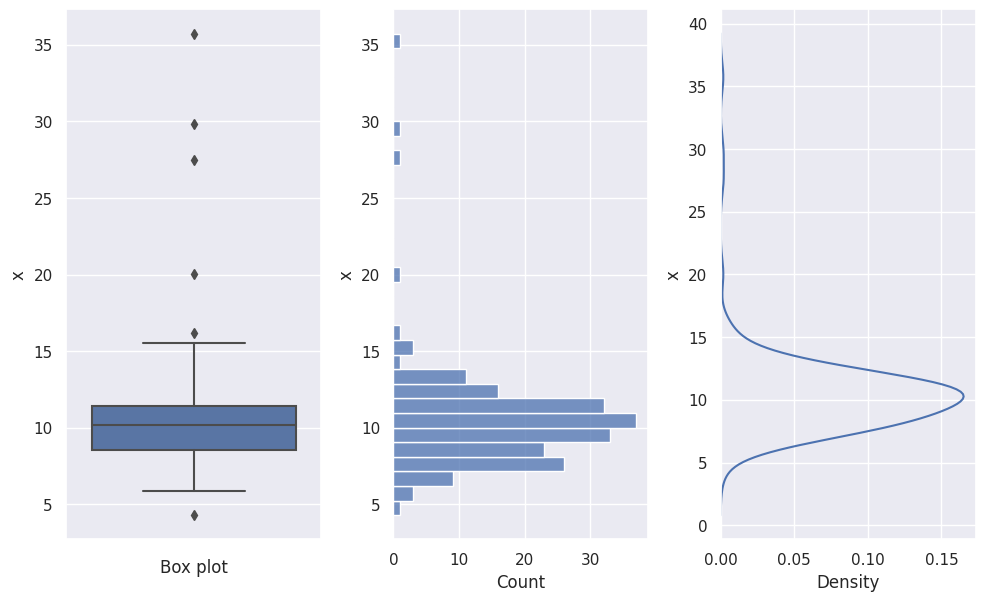

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))
fig.tight_layout()

sns.boxplot(data=df, y="x", ax=axs[0])
sns.histplot(data=df, y="x", ax=axs[1])
sns.kdeplot(data=df, y="x", ax=axs[2])
axs[0].set_xlabel("Box plot")

# Criando uma cópia do dataframe original
df_aux = df.copy()

# Calculando o Z-Score e seu valor absoluto
df_aux["x_zscore"] = (df_aux.x - df_aux.x.mean()) / df_aux.x.std()
df_aux["x_abs_zscore"] = df_aux.x_zscore.abs()

# Ordenando os dados de maneira decrescente
df_aux.sort_values(by="x_abs_zscore", ascending=False)[["x", "x_abs_zscore"]].head(10)

Vamos remover os outliers da variável `x` utilizando uma rotina recursiva de filtro por z-score, conforme descritivo apresentado na função definida na célula abaixo:

,148,143,1,123,73,26,46,57,185,156
index,156.000000,150.000000,1.000000,129.000000,74.000000,26.000000,47.000000,58.000000,194.000000,165.000000
x,13.417672,7.690273,9.777608,12.117938,10.868616,11.288319,7.917467,9.447145,10.552668,9.746875
y,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


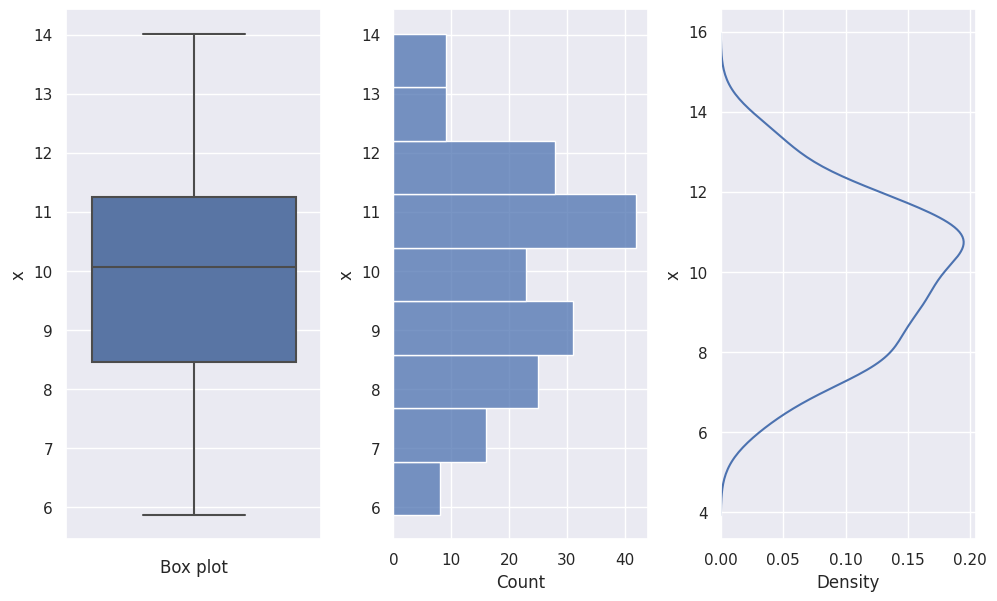

In [6]:
def remove_outliers_using_abs_zscore(dataframe, column, cutpoint=2.576, maxiter=5):
    """
    Remove outliers da variável `column` de um conjunto de dados `dataframe` utilizando 
    um ponto de corte `cutpoint`. Esta função é executada recursivamente até que nenhum
    ponto possa ser removido do conjunto de dados, ou o número de iterações seja maior
    ou igual à `maxiter`.
    
    :dataframe: Um dataframe do pandas
    :column: O nome da coluna alvo que contém a variável numérica seguindo uma distribuição gaussiana
    :cutpoint: Ponto de corte (valores acima de `cutpoint` desvios padrão serão removidos do conjunto)
    :maxiter: Número máximo de iterações
    """
    aux_df = dataframe.copy()
    iter_n = 0

    for it in range(maxiter):
        aux_df["z_score"] = (aux_df[column] - aux_df[column].mean()) / aux_df[column].std()
        cut_indexes = aux_df["z_score"].abs() >= cutpoint
        
        if (cut_indexes.sum()) == 0:
            break
        
        aux_df = aux_df[~cut_indexes]
    
    return dataframe.iloc[aux_df.index.values].copy().reset_index()


df1 = remove_outliers_using_abs_zscore(df, "x")

fig, axs = plt.subplots(1, 3, figsize=(10, 6))
fig.tight_layout()

sns.boxplot(data=df1, y="x", ax=axs[0])
sns.histplot(data=df1, y="x", ax=axs[1])
sns.kdeplot(data=df1, y="x", ax=axs[2])
axs[0].set_xlabel("Box plot")

df1.sample(10).T

Para encontrar os outliers da variáveis categórica $y$, utiliza-se a frequência (contagem) de ocorrências
da classe. Descartam-se as classes com um número muito baixo de ocorrências.

Text(0.5, 1.0, 'Proporção')

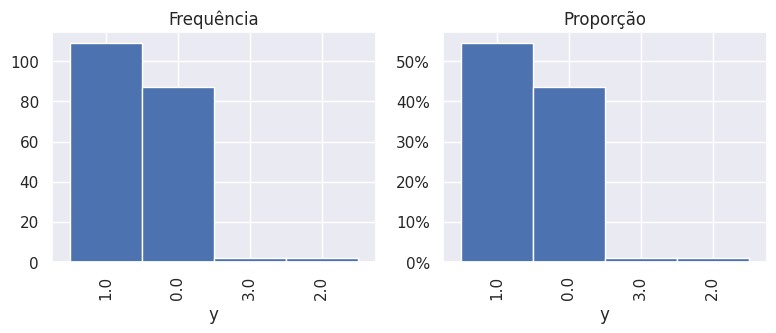

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()

df.y.value_counts(dropna=False, normalize=False).plot.bar(width=1, ax=axs[0])
axs[0].set_title("Frequência")

df.y.value_counts(dropna=False, normalize=True).mul(100).plot.bar(width=1, ax=axs[1])
axs[1].yaxis.set_major_formatter(mticker.PercentFormatter())
axs[1].set_title("Proporção")

Neste estudo de caso, devemos descartas as categorias 2 e 3 da variável categórica `y`

In [8]:
# podemos usar a função `query` do pandas para selecionar um subconjunto de dados 
# de um dataframe
df.query("y.isin([0, 1])")

,x,y
0,9.896072,0.0
1,9.777608,1.0
2,12.083594,1.0
3,7.486521,1.0
4,11.490775,1.0
...,...,...
195,10.866731,1.0
196,10.487950,0.0
197,10.822797,0.0
198,11.765554,0.0


Detectando outliers em um conjunto de variáveis (análise multivariada)
----------------------------------------------------------------------------------------------------

Neste segundo exemplo, criaremos um outro conjunto de dados sintéticos, com duas variávies numéricas, de acordo com a seguinte equação:

\begin{equation}
    p = 1.57 h + e + a + b
\end{equation}

onde $p$ é o peso da pessoa (em kg), $h$ é a altura da pessoa, e $e$ é um ruído branco $e \sim N (0, 1)$, e $a$ e $b$ são vetores de perturbação (utilizados para amplificar os outliers sintéticos).
Suponhamos que $h$ seja uma variável aleatória, tal que $h \sim N (1.74, 0.10^2)$.

**Obs.**: Ruído branco é o nome dado à uma distribuição Gaussiana com média 0 e variância $\sigma^2$.

In [9]:
random.seed(18) # Fixando a semente aleatória para reprodução de resultados
np.random.seed(18)

# Quantidade de amostras
samples = 200

def perturbacao(samples, std, prob):
    """
    Gerador de perturbação Gaussiana.
    
    :samples: Número de amostras no vetor de perturbação.
    :std: Desvio padrão da perturbação Gaussiana.
    :prob: Probabilidade de ocorrência.
    """
    return std * np.random.randn(samples) * (np.random.rand(samples) < prob) * 1.0

a = perturbacao(samples, 0.2, 0.01)
b = perturbacao(samples, 10, 0.05)
e = 1 * np.random.randn(samples)

h = 0.10 * np.random.randn(samples) + 1.74 + a
p = 45 * h + e + b

In [10]:
def eigsorted(cov):
    """
    Encontra os auto-valores e auto-vetores de uma matriz de variância-covariância.
    Os auto-valores e auto-vetores nos ajudam a normalizar amostras de distribuições
    multivariadas.
    
    :cov: Matriz de variância-covariância.
    """
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]
    
def plot_cov_ellipse(mean, cov, nstd=2, ax=None, **kwargs):
    """
    Função utiliada para desenhar uma elipse que representa o intervalo
    de confiança de uma distribuição bivariada (Gaussiana em duas dimensões).
    
    :mean: Ponto central da elipse (gaussiana bivariada)
    :cov: Matrix de variância-covariância da distribuição gaussiana bivariada
    :nstd: Limite de confiança, em termos de desvios padrões
    :ax: Handler em que a elipse deve ser desenhada
    """


    if ax is None:
        ax = plt.gca()
    
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

Primeiramente, vamos observar a relação entre peso e altura. Na sintetização dos dados, salvamos os índices das
perturbações (outliers sintéticos) adicionados à amostra, os quais são representados por pontos em vermelho em nosso gráfico de disperção. 

Text(0, 0.5, 'Altura')

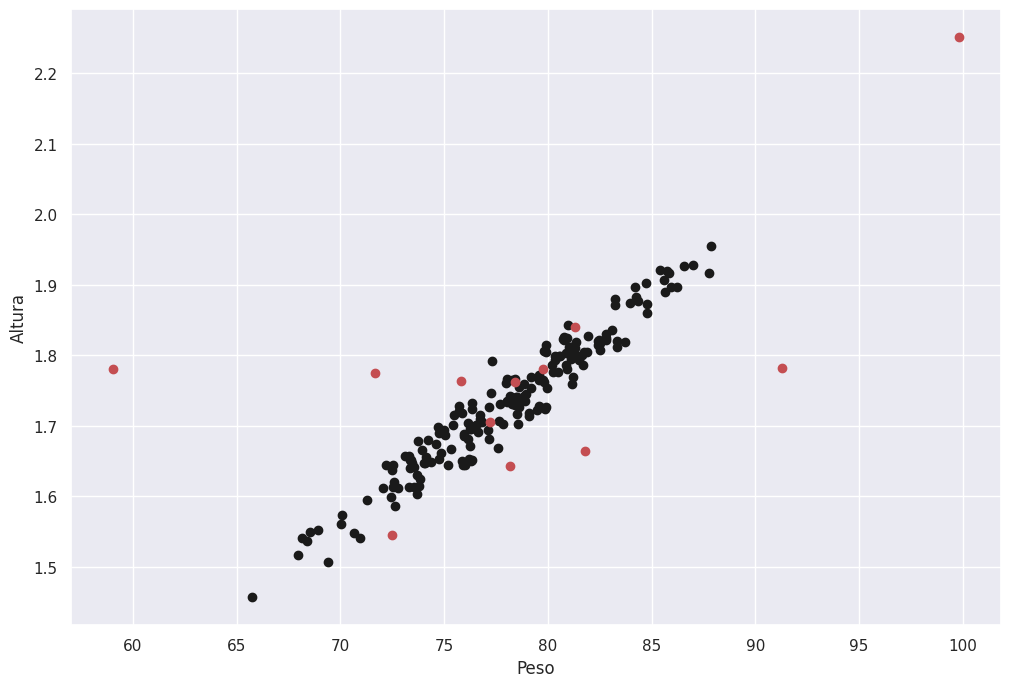

In [11]:
# Visualizando os dados por meio de um scatter-plot (gráfico de disperção)
fig = plt.subplots(figsize=(12, 8))
normal_idx = (a == 0) & (b == 0)
plt.plot(p[normal_idx], h[normal_idx], 'k.', ms=12)
plt.plot(p[~normal_idx], h[~normal_idx], 'r.', ms=12)
plt.xlabel("Peso")
plt.ylabel("Altura")

Nota-se que existe uma relação linear entre Peso e Altura, e qua a distribuição das amostras se assemelha a uma **distribuição multivariada normal**. Podemos calcular o centróide desta distribuição usando a função ``mean``, e a matriz de variância-covariância com a função ``cov``, ambas da biblioteca ``numpy``.

Para visualizar os limiares da distribuição, dado um intervalo de confiança, desenhando uma elipse parametrizada por meio da centróide e dos auto-vetores da matriz de variância-covariância da distribuição.

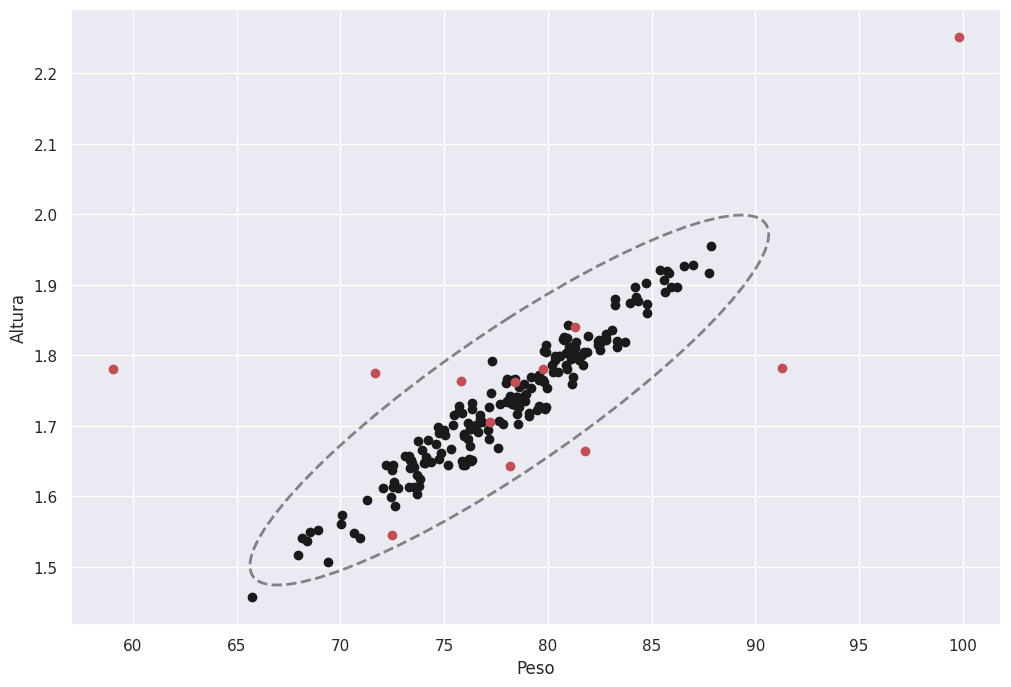

In [12]:
# Visualizando os dados por meio de um scatter-plot (gráfico de disperção)
fig = plt.subplots(figsize=(12, 8))
normal_idx = (a == 0) & (b == 0)
plt.plot(p[normal_idx], h[normal_idx], 'k.', ms=12)
plt.plot(p[~normal_idx], h[~normal_idx], 'r.', ms=12)
plt.xlabel("Peso")
plt.ylabel("Altura")

# Adicionando ao scatter plot uma elipse, representando o desvio de 2.576 (99%) desvios padrões
# da centróide da distribuição dos dados.
data = np.vstack([p, h]).T
mean = data.mean(axis=0)
cov = np.cov(data, rowvar=0)
plot_cov_ellipse(mean, cov, nstd=2.576, color="k", ls="--", lw=2, fc=None, fill=False, alpha=0.5)

Também podemos utilizar a pacote ``stats`` da biblioteca sicpy, para nos auxiliar na criação de um gráfico de contorno (projeção 3D sobre um plano 2D).

Text(0, 0.5, 'Altura')

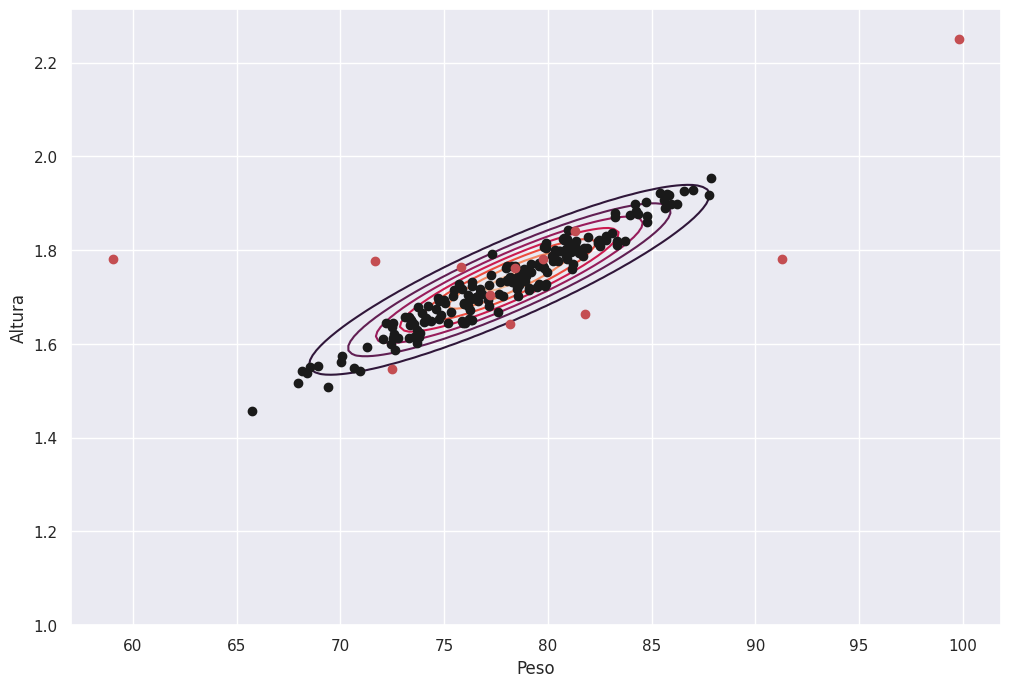

In [13]:
from scipy.stats import multivariate_normal
mvn = multivariate_normal(mean=mean, cov=cov)

X, Y = np.meshgrid(np.linspace(65, 90, 100), np.linspace(1, 2, 100))
Z = np.zeros_like(X)

for i in range(100):
    for j in range(100):
        Z[i][j] = mvn.pdf([X[i][j], Y[i][j]])
        
fig = plt.subplots(figsize=(12, 8))
plt.contour(X, Y, Z)
normal_idx = (a == 0) & (b == 0)
plt.plot(p[normal_idx], h[normal_idx], 'k.', ms=12)
plt.plot(p[~normal_idx], h[~normal_idx], 'r.', ms=12)
plt.xlabel("Peso")
plt.ylabel("Altura")

A receita de bolo para a filtragem de um conjunto de variáveis aleatórias (que seguem distribuição normal) é dado por:
 - Passo 1: Calcule a média de cada variável aleatória;
 - Passo 2: Calcule a matriz de variância-covariância do conjunto de variáveis aleatórias;
 - Passo 3: Encontre os auto-vetores da matriz de variância-covariância;
 - Passo 4: Subtraia o valor médio, calculado no Passo 1, das observações originais (Translação);
 - Passo 5: Rotacione as observações transladadas utilizando a matriz formada pelas auto-vetores encontrados no Passo 3 (Rotação);
 - Passo 6: Estardardize as observações rotacionadas para que a variância de cada eixo seja igual à 1 (Estandardização);
 - Passo 7: Calcule a distância de cada ponto estandardizado à origem, e utilize-o para filtrar os dados. A distância pode ser interpretada como o Z-Score de uma análise unidimensional (Filtragem);
 
Observações:
  - A multiplicação do conjunto de dados transladado pela matriz de transformação formada pelos auto-vetores da matriz de variância-covariância **REMOVE** a covariância existente nas variáveis originais;
  - A estandardização dos dados rotacionados nos permite parametrizar a distribuição multivariada facilmente com coordenadas polares. Ao selecionar pontos de corte para detecção de outliers, estamos, na essencia, delimitando o espaço $\mathbb{R}^N$ (onde $N$ é o número de variáveis aleatórias) com a utilização de uma hiperesfera;
  
Um exemplo ilustrativo deste processo é apresentado na célula abaixo:

(-4.88416709232317, 9.748285552530444, -9.523458106165268, 5.108994538688345)

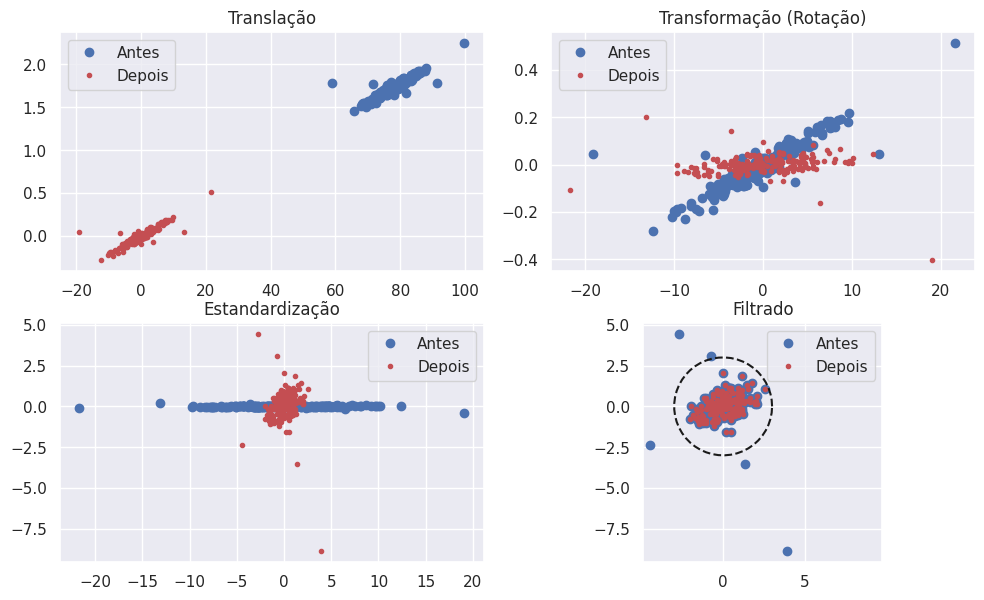

In [14]:
# calcula a médio de cada coluna
mean = data.mean(axis=0)

# calcula a matriz de variância-covariância entre as variáveis
cov = np.cov(data, rowvar=0)

# encontra os auto-valores e auto-vetores da matriz de variância-covariância
# ordenados de forma decrescente por auto-valores.
vals, vecs = eigsorted(cov)

# translada pontos para a origem (remove a média)
t = data - mean

# rotaciona pontos de acordo matriz de transformação (auto-vetores)
r = t.dot(vecs)

# estandardize dados com variância
zstd = np.sqrt(np.diag(np.cov(r, rowvar=0)))
z = r / zstd

# filtra baseando-se em distância do centro
d = np.sqrt((z ** 2).sum(axis=1))
f = z[np.abs(d) < 3 , :]

def compare(old, new, title, ax = None):
    if ax == None:
        fig, ax = plt.subplots()
    ax.plot(old[:, 0], old[:, 1], 'bo')
    ax.plot(new[:, 0], new[:, 1], 'r.')
    ax.legend(["Antes", "Depois"])
    ax.set_title(title)
    return ax

fig, axs = plt.subplots(2, 2)
fig.tight_layout()


ax = compare(data, t, "Translação", axs[0][0])
ax = compare(t, r, "Transformação (Rotação)", axs[0][1])
ax = compare(r, z, "Estandardização", axs[1][0])
ax = compare(z, f, "Filtrado", axs[1][1])

theta = np.linspace(0, 2 * np.pi, 50)
radius = 3 * np.ones_like(theta)

ax.plot(radius * np.cos(theta), radius * np.sin(theta), 'k--')
ax.axis("square")


Vamos remover os outliers deste conjunto multimodal utilizando uma função similar à apresentada no caso unimodal. 
A função e seu descritivo (`docstring`) é apresentada na célula abaixo:

<Axes: xlabel='p', ylabel='h'>

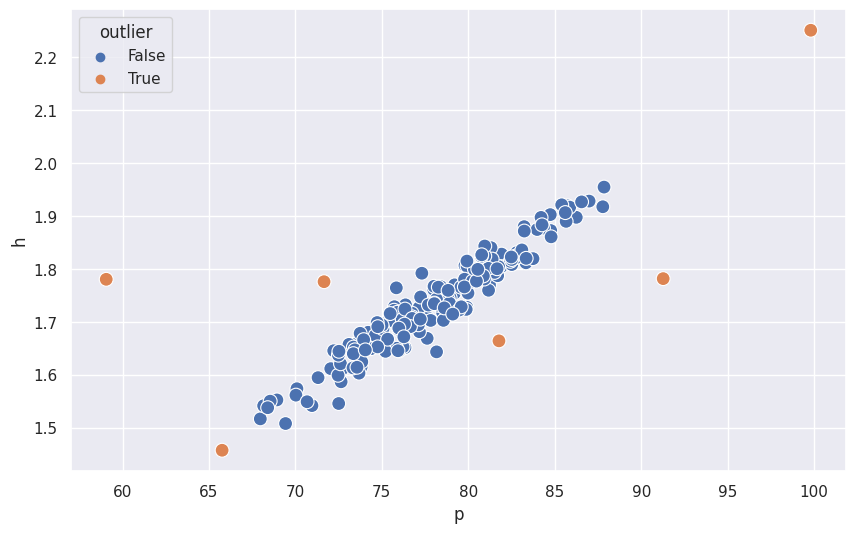

In [15]:
def filter_multinorm(dataframe, columns, n_stds=2.576):
    """
    Remove outliers de um conjunto de variáveis aleatórias com distribuição normal `columns` 
    de um conjunto de dados `dataframe` utilizando o método z-score n-dimensional. O ponto
    de corte para exclusão da amostra é dado pelo número de desvios padrões `n_stds` de distância da
    origem após aplicação do processo de estandardização dos dados.
    
    Esta função não é executada recursivamente, mas pode ser facilmente estendida para este fim seguindo
    os passos da função de exemplo para o caso unimodal.
    
    :dataframe: Um dataframe do pandas
    :columns: O nome das colunas alvo que contém as variáveis aleatórias normais
    :n_stds: O número de desvios padrões de distância da origem para utilizar como `cutpoint`
    """
    dataframe = dataframe.copy()
    X = dataframe[columns].values
    mean = X.mean(axis=0)
    cov = np.cov(X, rowvar=0)
    
    vals, vecs = eigsorted(cov)
    Z = (X - mean).dot(vecs)
    Zstd = np.sqrt(np.diag(np.cov(Z, rowvar=0)))
    Zvals = Z / Zstd
    
    # Distances from origin
    D = np.sqrt((Zvals ** 2).sum(axis=1))
    dataframe["outlier"] = np.abs(D) >= n_stds
    return dataframe

# Transformando os vetores sintéticos em um dataframe do pandas
df = pd.DataFrame(np.vstack([p, h]).T, columns=["p", "h"])

# Aplicando a rotina 
df = filter_multinorm(df, ["p", "h"])
 
sns.scatterplot(data=df, x="p", y="h", hue="outlier", s=100)

Curiosidade - Teorema Central do Limite
=================================

Afirma que, quando o tamanho de uma amostra aumenta, a distribuição amostral da **média** converge para uma distribuição normal (gaussiana).

Na célula abaixo, altere o valor da variável **samples**, e perceba que, quanto maior for o seu valor, mais próxima estará de uma **gaussiana** a distribuição da **média** das amostras aleatórias.

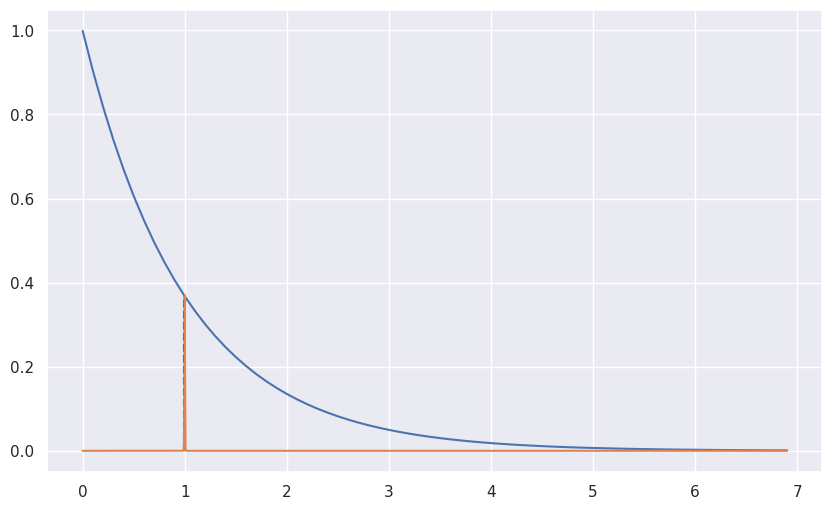

In [16]:
from scipy.stats import expon, norm

lower_bound = 0.001
upper_bound = 1 - lower_bound
samples = 100000

x = np.arange(expon.ppf(lower_bound), expon.ppf(upper_bound), 0.1)
y = expon.pdf(x)

plt.plot(x, y)

exp_mean = (x * y * 0.1).sum()
plt.plot([exp_mean, exp_mean], [0, expon.pdf(exp_mean)], 'k--')

expon.rvs(size=samples).mean()

y_mean = []
for i in range(x.shape[0]):
    y_mean.append(expon.rvs(size=samples).mean())
y_mean = np.array(y_mean)

gauss = norm(*norm.fit(y_mean))
x_gauss = np.arange(x.min(), x.max(), 0.0001)
y_gauss = gauss.pdf(x_gauss)
plt.plot(x_gauss, y_gauss / gauss.pdf((x_gauss * y_gauss * 0.0001).sum()) * expon.pdf(exp_mean))